Load modules.

In [1]:
from timeit import timeit

import numpy as np
from matplotlib import pyplot as plt

from config import DATADIR

Set I/O directories.

In [2]:
FIGDATADIR = DATADIR / "Figure_12"

Define equivalent window convolution matrix multiplication operations.

In [3]:
def winconv_mul_symb(wc_mat, unw_model_vec):
    return wc_mat @ unw_model_vec


def winconv_mul_dot(wc_mat, unw_model_vec):
    return np.dot(wc_mat, unw_model_vec)


def winconv_mul_mat(wc_mat, unw_model_vec):
    return np.matmul(wc_mat, unw_model_vec)

In [4]:
EXEC_FUNC_NAMES = [
    'winconv_mul_symb',
    'winconv_mul_dot',
    'winconv_mul_mat',
]
EXEC_FUNC_LABELS = [
    r"$\mathtt{@}$",
    r"$\mathtt{numpy.dot}$",
    r"$\mathtt{numpy.matmul}$",
]
REF_FUNC_IDX = 0

Define scaling tests.

In [5]:
DIM2 = 1024   # baseline dimensions
NUMCOMP = 4   # representative number of multipole components
NUMRUN = 100  # baseline number of runs

In [6]:
def find_scaling(multipliers, dim2_base=DIM2, numruns=NUMRUN):

    if np.isscalar(numruns):
        # Interprete strings as the same number of runs for all multipliers.
        if isinstance(numruns, str):
            nruns = [int(numruns)] * len(multipliers)
        # Interprete numbers as a maximum baseline number of runs.
        else:
            nruns = [
                -(-numruns // factor)
                for factor in multipliers
            ]
    else:
        # Interprete sequences as the number of runs for each multiplier.
        nruns = numruns

    namespace = globals()

    scaling = {exec_func: [] for exec_func in EXEC_FUNC_NAMES}
    for factor, nrun_ in zip(multipliers, nruns):
        dim2 = dim2_base * factor
        wc_mat = np.random.rand(dim2, NUMCOMP * dim2)
        unw_model_vec = np.random.rand(NUMCOMP * dim2)

        namespace_ = namespace.copy()
        namespace_.update(locals())

        for exec_func in EXEC_FUNC_NAMES:
            exec_time = timeit(
                f'{exec_func}(wc_mat, unw_model_vec)',
                globals=namespace_, number=nrun_
            )
            scaling[exec_func].append(exec_time / nrun_)

    return scaling

Perform scaling tests.

In [7]:
scaling_factors = [2, 4, 8, 12, 16]
scaling_runs = [10, 10, 10, 10, 10]

scaling_results_filename = "winconv-matmul-timescaling.npz"
scaling_results_file = FIGDATADIR / scaling_results_filename
try:
    scaling_results = np.load(scaling_results_file)
except FileNotFoundError:
    scaling_results = find_scaling(scaling_factors, numruns=scaling_runs)
    np.savez(scaling_results_file, **scaling_results)

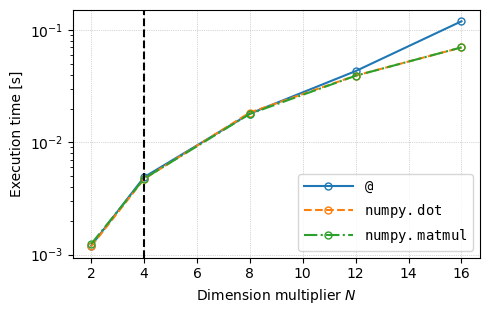

In [8]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5., 3.25))

EXEC_FUNC_LINESTYLES = ['-', '--', '-.']

for exec_func_, label_, ls_ in zip(
    EXEC_FUNC_NAMES,
    EXEC_FUNC_LABELS,
    EXEC_FUNC_LINESTYLES,
):
    ax.semilogy(
        scaling_factors, scaling_results[exec_func_],
        marker='o', markersize=5, mfc='none',
        ls=ls_,
        label=label_
    )

ax.axvline(x=4, lw=1.5, ls='--', c='k')

ax.grid(True, which='major', lw=0.5, ls=':')

ax.margins(x=0.05, y=0.05)

ax.set_xlabel(fr'Dimension multiplier $N$');
ax.set_ylabel('Execution time [s]');

ax.legend(handlelength=3.5);

fig.tight_layout()